In [1]:
import os, pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

Unpickling what we prepared before

In [2]:
path = "pickles/"
with open(path+"train3.pickle", "rb") as file:
    proteins = pickle.load(file)

In [3]:
def displaySample(proteins):
    fig = plt.figure(1, figsize=(17, 17))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.2)

    grid[0].imshow(proteins["0"][0]/255, interpolation="bilinear")
    grid[0].tick_params(axis='both', which='both', bottom='off', top='off', 
                    labelbottom='off', right='off', left='off', labelleft='off')

    grid[1].imshow(proteins["1"][0]/255, interpolation="bilinear")
    grid[1].tick_params(axis='both', which='both', bottom='off', top='off', 
                    labelbottom='off', right='off', left='off', labelleft='off')

    grid[2].imshow(proteins["2"][0]/255, interpolation="bilinear")
    grid[2].tick_params(axis='both', which='both', bottom='off', top='off', 
                    labelbottom='off', right='off', left='off', labelleft='off')

    grid[3].imshow(proteins["3"][0]/255, interpolation="bilinear")
    grid[3].tick_params(axis='both', which='both', bottom='off', top='off', 
                    labelbottom='off', right='off', left='off', labelleft='off')

C:\Users\NocTuro\Miniconda3\envs\tf\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


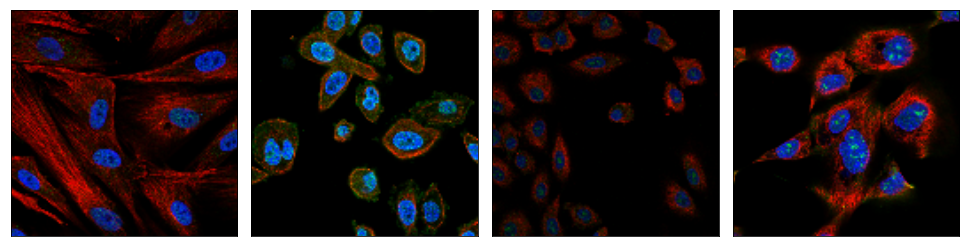

In [4]:
displaySample(proteins)

The extraction went well, we can proceed.  

We will now standardize the data, but to do that, having all of them in the same list is more convenient.

In [16]:
labels = []
images = []
for kind in proteins.keys():
    for protein in proteins[kind]:
        images.append(protein)
        labels.append(kind)
        
print("{} images of proteins available ".format(len(images)))
#To clear memory, maybe useful
#proteins = None

952 images of proteins available 


In [17]:
mean = np.mean(images)
std = np.std(images)
print(mean, std)

13.77399810021665 31.495434736812904


In [18]:
images = np.array([(images[i] - mean) / std for i in range(len(images))])

Now that the data are normalized, we proceed to shuffle the set

In [19]:
images, labels = shuffle(images, labels)

We proceed to transform our labels into dummy variables and make sure to leave out one of the labels to avoid the perfect multicollinearity at the classification step.

In [20]:
dummies = np.zeros((len(labels),28))
dummies[np.arange(len(labels)), np.array(labels, dtype='int')] = 1
#And we consider the first column to be the 'default' one
dummies[:,0] = 0

Calculating the total amount of available images

In [32]:
nb_batches = 3
nb_images = 0
for i in range(nb_batches):
    with open("pickles/labels"+str(i)+".pickle", "rb") as file:
        labels = pickle.load(file)
        nb_images += len(labels)
print(nb_images)

2945


### Neural network part

In [6]:
#Clearing past graphs
tf.reset_default_graph()   

learning_rate = 0.05

#placeholders definition
input_data = tf.placeholder(tf.float32, (None, 128, 128, 3))
input_labels = tf.placeholder(tf.int32, (None, 28))

#layers definition
conv1 = tf.layers.conv2d(input_data, 16, (5, 5), (1, 1), activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2))

conv2 = tf.layers.conv2d(pool1, 16, (5, 5), (1, 1), activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2))

conv3 = tf.layers.conv2d(pool2, 32, (3, 3), (1, 1), activation=tf.nn.relu)
pool3 = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2))

conv4 = tf.layers.conv2d(pool3, 32, (3, 3), (1, 1), activation=tf.nn.relu)
pool4 = tf.layers.max_pooling2d(conv4, (2, 2), (2, 2))

flattened = tf.contrib.layers.flatten(pool4)

# define fully-connected (or dense) layers
dense1 = tf.layers.dense(flattened, 100)
logits = tf.layers.dense(dense1, 28)

# define loss and training operation
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=input_labels, logits=logits))
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# calcualte average accuracy over a batch of images
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(input_labels, 1)), tf.float32))

In [35]:
#defining parameters of training run
epoch = 3
sub_batch_size = 200
nb_steps = nb_images * epoch // sub_batch_size
log_frequency = 1
batch_range = [i for i in range(nb_batches)]
batch_indices = []
for i in range(epoch):
    batch_indices += batch_range
    
print(nb_steps)
    
with tf.Session() as sess:
    #Initialization
    sess.run(tf.global_variables_initializer())
    batch_run = 0
    
    for step_index in range(nb_steps):
        #On first step
        if step_index == 0:
            with open(path+"images0.pickle", "rb") as file:
                images = pickle.load(file)
            with open(path+"labels0.pickle", "rb") as file:
                labels = pickle.load(file)
            sub_batch_index = 0
            batch_size = len(labels)
                
        #If we are crossing images sets
        elif (sub_batch_index + 1)* sub_batch_size > batch_size:
            before_crossing_images = images[-(batch_size - (sub_batch_index-1)*sub_batch_size):]
            before_crossing_labels = labels[-(batch_size - (sub_batch_index-1)*sub_batch_size):]
            with open(path+"images"+str(batch_indices[batch_run])+".pickle", "rb") as file:
                images = np.concatenate((before_crossing_images, pickle.load(file)))
            with open(path+"labels"+str(batch_indices[batch_run])+".pickle", "rb") as file:
                labels = np.concatenate((before_crossing_labels, pickle.load(file)))
            sub_batch_index = 0
            batch_size = len(labels)
            batch_run += 1
            
        indices = [i for i in range(sub_batch_size*sub_batch_index, sub_batch_size*(sub_batch_index+1))]
        print(batch_size, batch_index, sub_batch_index)
        #performing training
        batch_loss, batch_accuracy, _ = sess.run([loss, accuracy, train_op], feed_dict={
            input_data: images.take(indices, axis=0),
            input_labels: labels.take(indices, axis=0)
            })
            
        #logging
        if step_index % log_frequency == 0:
            print('step:', step_index, ', loss:', batch_loss, ', training accuracy:', batch_accuracy)
        
        sub_batch_index += 1

44
963 3 0
step: 0 , loss: 3.4615862 , training accuracy: 0.06
963 3 1
step: 1 , loss: 3.1475012 , training accuracy: 0.125
963 3 2
step: 2 , loss: 3.1190526 , training accuracy: 0.14
963 3 3
step: 3 , loss: 2.9795282 , training accuracy: 0.155
1326 3 0
step: 4 , loss: 2.8442676 , training accuracy: 0.17
1326 3 1
step: 5 , loss: 2.9793394 , training accuracy: 0.15
1326 3 2
step: 6 , loss: 2.81411 , training accuracy: 0.205
1326 3 3
step: 7 , loss: 2.893354 , training accuracy: 0.18
1326 3 4
step: 8 , loss: 2.9815161 , training accuracy: 0.09
1326 3 5
step: 9 , loss: 2.7831476 , training accuracy: 0.18
1307 3 0
step: 10 , loss: 2.7037342 , training accuracy: 0.17
1307 3 1
step: 11 , loss: 2.856939 , training accuracy: 0.13
1307 3 2
step: 12 , loss: 2.8376396 , training accuracy: 0.09
1307 3 3
step: 13 , loss: 2.8786862 , training accuracy: 0.09
1307 3 4
step: 14 , loss: 2.9480078 , training accuracy: 0.125
1307 3 5
step: 15 , loss: 2.7915409 , training accuracy: 0.155
1308 3 0
step: 16 

In [22]:
uiui = ["a","b","c","d","e","f"]
current_batch_index = 880
batch_size = 45
nb_images = 900
cc = [i for i in range(current_batch_index, nb_images)] + [i for i in range(batch_size - (nb_images - current_batch_index))]
print(uiui[-3:])

['d', 'e', 'f']


In [ ]:
epoch = 3
sub_batch_size = 200
log_frequency = 1
    
with tf.Session() as sess:
    #loading computation graph
    sess.run(tf.global_variables_initializer())
    #we have to loop accross the different batches of images that we made earlier
    for i in range(5):
        #deserializing
        with open(path+"train"+str(i)+".pickle", "rb") as file:
            proteins = pickle.load(file)
        labels = []
        images = []
        for kind in proteins.keys():
            for protein in proteins[kind]:
                images.append(protein)
                labels.append(kind)
        
        #normalization
        mean = np.mean(images)
        std = np.std(images)
        images = np.array([(images[i] - mean) / std for i in range(len(images))])
        
        #dummification
        dummies = np.zeros((len(labels),28))
        dummies[np.arange(len(labels)), np.array(labels, dtype='int')] = 1
        #And we consider the first column to be the 'default' one
        dummies[:,0] = 0
        
        #calculating required number of steps
        nb_images = images.shape[0]
        nb_steps = nb_images * epoch // sub_batch_size

        previous_batch_index = 0
    
        for step_index in range(nb_steps):
            #calculating the indices of images chosen in the epoch for the batch, potentially between 2 epochs
            current_batch_index = previous_batch_index
            if current_batch_index + sub_batch_size < nb_images:
                indices = [i for i in range(current_batch_index, current_batch_index + sub_batch_size)]
            else:
                indices = [i for i in range(current_batch_index, nb_images)] + [i for i in range(sub_batch_size - (nb_images - current_batch_index))]

            #performing training
            batch_loss, batch_accuracy, _ = sess.run([loss, accuracy, train_op], feed_dict={
                input_data: images.take(indices, axis=0),
                input_labels: dummies.take(indices, axis=0)
            })
            
            #logging
            if step_index % log_frequency == 0:
                print('step:', step_index, ', loss:', batch_loss, ', training accuracy:', batch_accuracy)
                    

In [10]:
# settings
num_steps = 1000
mini_batch_size = 64
log_frequency = 100

# how many steps are in one epoch (epoch = one pass through the dataset)
# e.g. number of training samples = 50, mini batch size = 10 => steps per epoch = 5
steps_per_epoch = train_dataset.shape[0] // mini_batch_size

with tf.Session() as session:
    
  # initialize all parameters of the neural network
  session.run(tf.global_variables_initializer())

  for step in range(num_steps):
        
    # step number relative to the current epoch (epoch = one pass through the dataset)
    # e.g. number of training samples = 50, step = 60 => epoch step = 60 % 50 = 10
    epoch_step = step % steps_per_epoch
        
    # start and end index for the current minibatch
    # e.g. mini batch size = 64, start = 10, end = 74 => take all images from index 10 to 74
    start = epoch_step * mini_batch_size
    end = (epoch_step +  1) * mini_batch_size
    
    # if this is the first step in the current epoch, shuffle the training set
    # we do this so that the model does not overfit on individual minibatches
    if epoch_step == 0:
        print("epoch", step // steps_per_epoch)
        train_dataset, train_labels = unison_shuffle(train_dataset, train_labels)
    
    # run one step of mini-batch gradient descent
    batch_loss, batch_accuracy, _ = session.run([loss, accuracy, train_op], feed_dict={
      input_data: train_dataset.take(range(start, end), axis=0, mode="wrap"),
      input_labels: train_labels.take(range(start, end), axis=0, mode="wrap")
    })
    
    # sometimes print the current loss
    if step % log_frequency == 0:
      print('step:', step, ', loss:', batch_loss, ', training accuracy:', batch_accuracy)
    
  print('Training finished after', num_steps, 'steps.')
  
  # evaluate the model on the validation set  
  validation_accuracy = session.run(accuracy, feed_dict={
    input_data: valid_dataset,
    input_labels: valid_labels
  })
    
  print('Validation accuracy', validation_accuracy, '.')

# we do not save the model so the parameters are forgotten right after the training finishes